In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage
import skimage.transform

import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from src.celeba_dataset import CelebA
from src.fadernet import Encoder,Decoder
%matplotlib inline

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(SEED)


data_path = '/home/alexliu/ADLxMLDS2017/final/data/img/'
spliting_path = '/home/alexliu/Downloads/CelebA/Eval/list_eval_partition.txt'
attribute_path = '/home/alexliu/Downloads/CelebA/Anno/list_attr_celeba.txt'



# Training Config
num_epoch = 500
display_step = 10
plot_step = 100
batch_size = 32
LEARNING_RATE = 1e-3
betas=(0.5, 0.999)

step_msg = 'Epoch {}\tGlobStep {}\tMSE {}\t'

# Model Config
target_attr = 'Smiling'
k_list = [3, 16, 32, 64, 128, 256, 512, 512]
IMAGE_SIZE = 256
num_tags = 2

# Load Dataset

Currently using single attribute

In [2]:
# Read the Attribute table & split dataset
attri_table = pd.read_csv(attribute_path,sep=' * ',skiprows=1)
split = pd.read_csv(spliting_path,header=None,sep=' ',index_col=0)
split = split.rename(columns={1:'Set'}).join(attri_table[target_attr])
split[target_attr] = split[target_attr]==1



# Read the spliting table & split dataset

train_set = [(idx.split('.')[0]+'.png',[1*row[target_attr],1*(not row[target_attr])]) 
             for idx,row in split.loc[split['Set']==0].iterrows()]
valid_set = [(idx.split('.')[0]+'.png',[1*row[target_attr],1*(not row[target_attr])]) 
             for idx,row in split.loc[split['Set']==1].iterrows()]
test_set = [(idx.split('.')[0]+'.png',[1*row[target_attr],1*(not row[target_attr])]) 
             for idx,row in split.loc[split['Set']==2].iterrows()]


# Create Dataset
debug_set = DataLoader(CelebA(train_set[:100],data_path), 
                       batch_size=batch_size, shuffle=False, num_workers=6, drop_last=True)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


# Load model

In [3]:
input_img = Variable(torch.zeros(batch_size, 3, IMAGE_SIZE, IMAGE_SIZE).float(),requires_grad=False)
given_attr = Variable(torch.zeros(batch_size, num_tags),requires_grad=False)

enc = Encoder(k_list)
dec = Decoder(k_list, num_tags, image_size=IMAGE_SIZE)
#dis = Discriminator(num_tags)

reconstruct_loss = nn.MSELoss()

if use_cuda:
    input_img = input_img.cuda()
    given_attr = given_attr.cuda()
    enc = enc.cuda()
    dec = dec.cuda()
    reconstruct_loss = reconstruct_loss.cuda()
    #dis = dis.cuda()

betas=(0.5, 0.999)
opt_enc_dec = optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=LEARNING_RATE, betas=betas)
#opt_dis = optim.Adam(dis.parameters(), lr=LEARNING_RATE, betas=betas)

# Train model

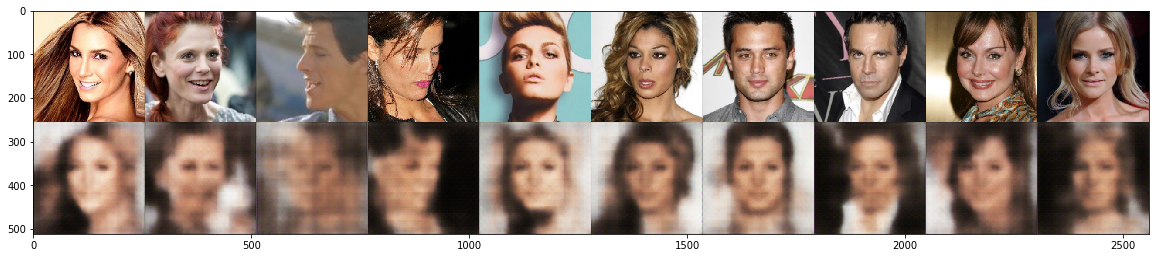

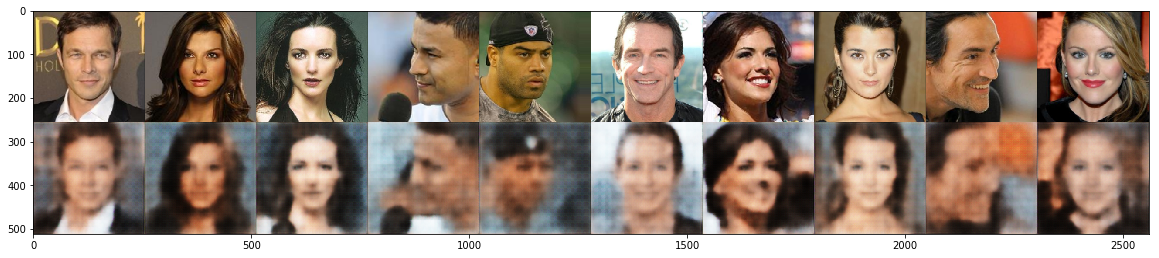

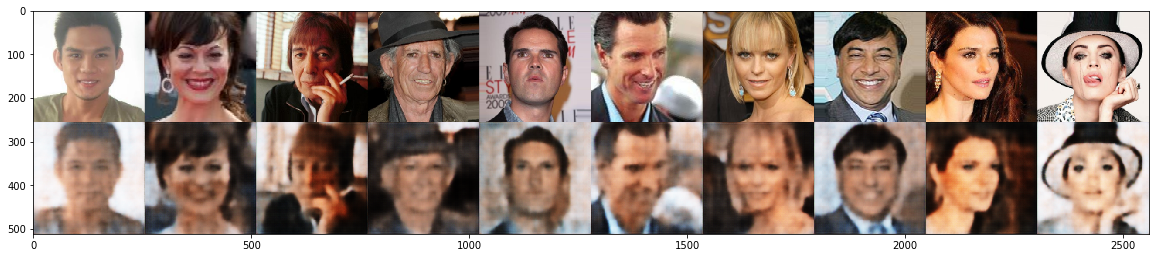

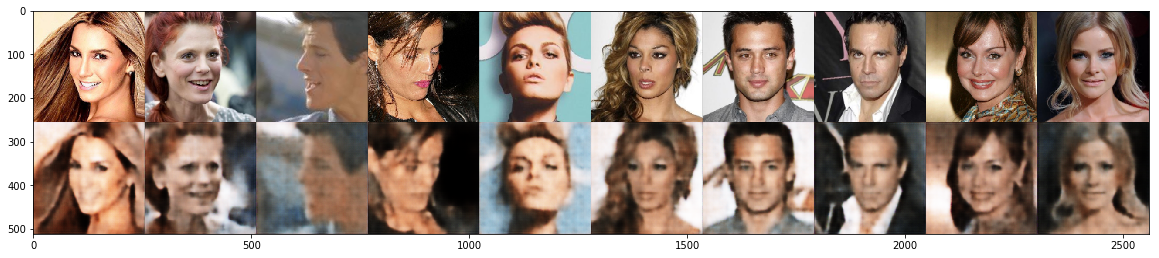

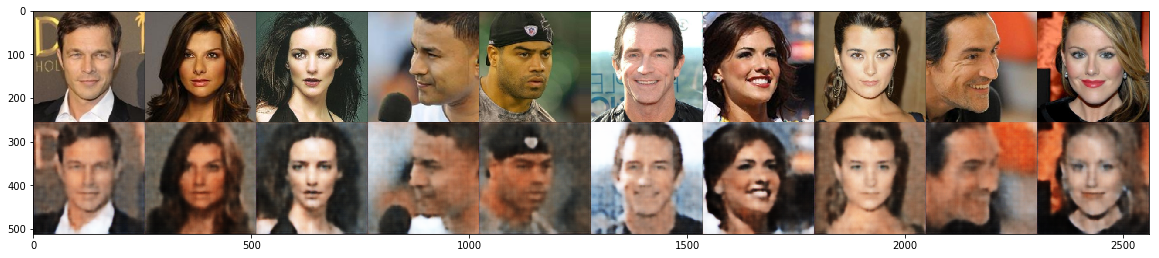

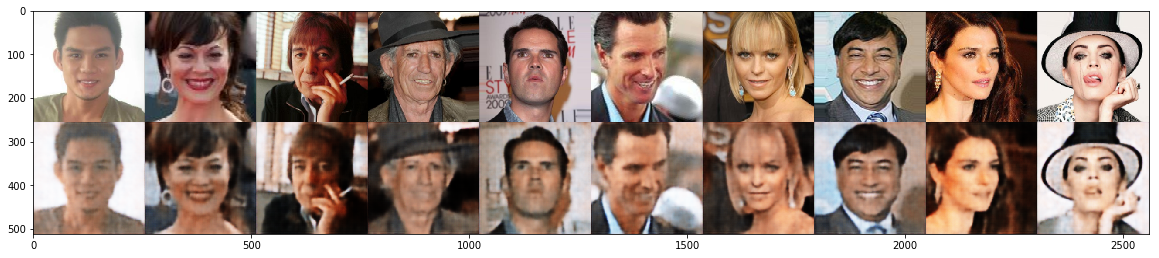

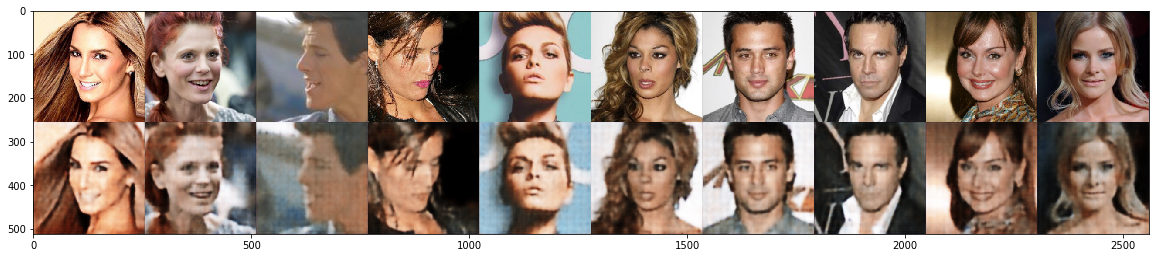

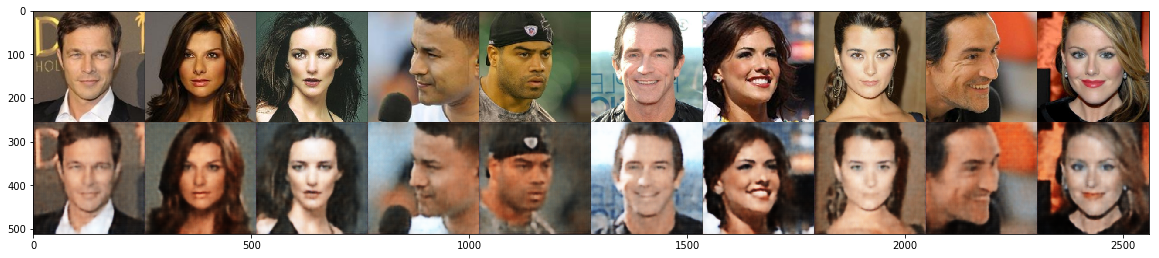

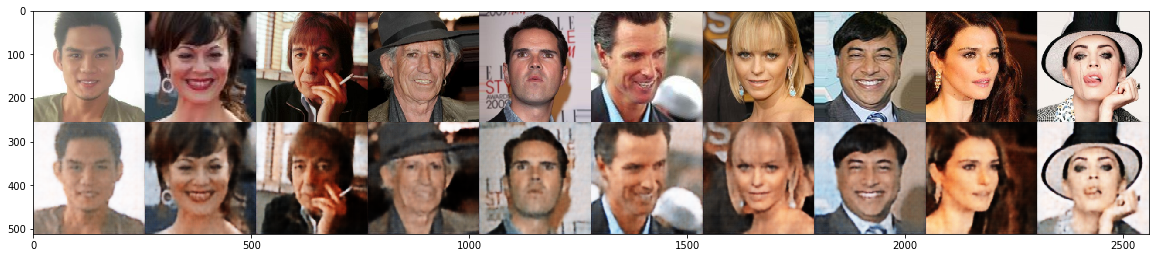

FileNotFoundError: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 42, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/alexliu/ADLxMLDS2017/final/src/celeba_dataset.py", line 19, in __getitem__
    return_img = mpimg.imread(self.file_path+self.data[idx][0])[:,:,:3]
  File "/home/alexliu/.local/lib/python3.5/site-packages/matplotlib/image.py", line 1310, in imread
    with open(fname, 'rb') as fd:
FileNotFoundError: [Errno 2] No such file or directory: '/home/alexliu/ADLxMLDS2017/final/data/img/000001.png'


In [4]:
global_step = 0
mse_history = []

for epoch in range(num_epoch):
    
    for (batch_img,batch_attr) in debug_set:
        
        # Load batch
        input_img.data.copy_(batch_img)
        given_attr.data.copy_(batch_attr)
        
        # Train AE
        opt_enc_dec.zero_grad()
        
        E_x = enc(input_img)
        reconstruct_img = dec(E_x,given_attr)
        
        loss = reconstruct_loss(reconstruct_img,input_img)
        loss.backward()
        
        
        opt_enc_dec.step()
        
        # End of step
        mse_history.append(loss.cpu().data.numpy()[0])
        global_step += 1
        
        if global_step%display_step == 0:
            print(step_msg.format(epoch+1,global_step,np.mean(mse_history)),end='\r',flush=True)
            mse_history=[]
            
        if global_step% plot_step ==0:
            tmp = []
            src_image = [(1+img)/2 for img in input_img.cpu().data.numpy().transpose(-4,-2,-1,-3)[:10]]
            gen_image = [(1+img)/2 for img in reconstruct_img.cpu().data.numpy().transpose(-4,-2,-1,-3)[:10]]
            tmp.append(np.concatenate(src_image,axis=-2))
            tmp.append(np.concatenate(gen_image,axis=-2))
            fig = plt.figure(figsize=(20, 10))
            tmp = np.squeeze(np.concatenate(tmp,axis=-3))
            plt.imshow(tmp)
            plt.show()
        

# Remain part is dummy, ignore

In [9]:
return_img = mpimg.imread(data_path+'000800.png')

In [10]:
return_img.shape

(256, 256, 4)

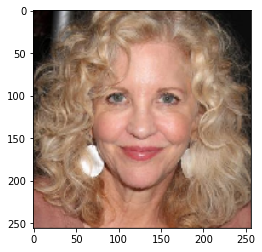

In [22]:
plt.imshow(return_img[:,:,:3])

In [126]:
attri_table['Smiling'].value_counts()

-1    104930
 1     97669
Name: Smiling, dtype: int64

In [57]:
attri_table.columns

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')